# Comparing _autodifferentiation_ & _finite differences_ in Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal

/home/LSC/vitorelli/.local/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
##Local settings
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import galsim
import tensorflow as tf

import tqdm

## Generate Data

In [4]:
seed = 31415
rng = np.random.RandomState(seed)

In [5]:
img_noise = 1.0e-6
psf_noise = img_noise/10
scale = 0.2
stamp_size = 45
psf_fwhm = 0.9
gal_hlr = 0.7

In [6]:
def make_data(N=1,
  psf_noise = 1.0e-5,
  img_noise = 1.0e-4,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    psf_image += rng.normal(scale=psf_noise, size=psf_image.shape)
    gal_image += rng.normal(scale=img_noise, size=gal_image.shape)
    gal_image = tf.convert_to_tensor(gal_image)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [7]:
gal_images, psf_images = make_data(N=1,psf_noise = psf_noise,
                                  img_noise = img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0,.01,-0.01],gal_g2=[0.0,.0,.01])

Text(0.5, 1.0, 'psf model')

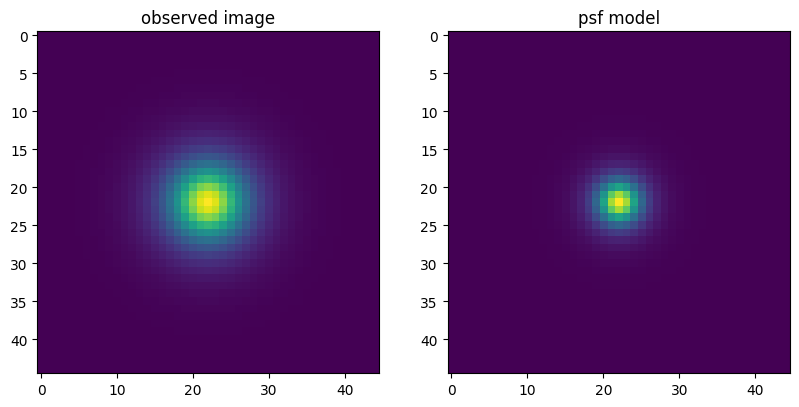

In [8]:
style.use('default')
figure(figsize=(15,5))
subplot(131)
imshow(gal_images[0]); title('observed image')
subplot(132)
imshow(psf_images[0]); title('psf model')


## Generate a 20% larger PSF for reconvolution.

In [9]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

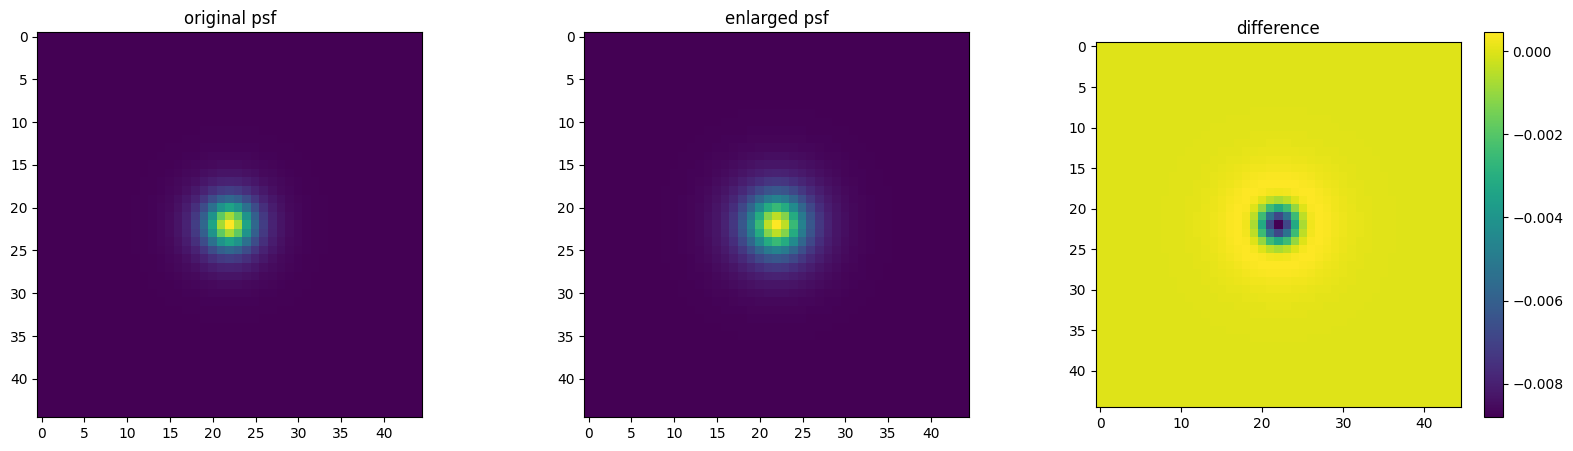

In [10]:
style.use('default')
figure(figsize=(20,5))
subplot(131)
imshow(psf_images[0]); title('original psf')
subplot(132)
imshow(reconv_psf_image[0]); title('enlarged psf')
subplot(133)
imshow(reconv_psf_image[0] - psf_images[0]); title('difference');colorbar()

## Test GalFlow Deconv/Reconv

/home/LSC/vitorelli/.local/lib/python3.9/site-packages/tensorflow_addons/utils/resource_loader.py:78: UserWarning: You are currently using TensorFlow 2.8.0 and trying to load a custom op (custom_ops/image/_resampler_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.7.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops by setting environment variable `TF_ADDONS_PY_OPS=1` or using `tfa.options.disable_custom_kernel()` in your code. To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.7.0 and strictly below 2.8.0.
 Note that nightly versions of TensorFlow, as well as non-pip Tenso

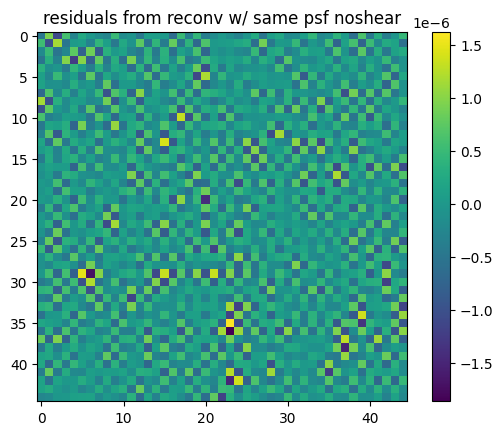

In [11]:
style.use('default')
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],[[0.0,0.0]])[0]-gal_images[0]);title('residuals from reconv w/ same psf noshear');colorbar()


## GalFlow vs GalSim

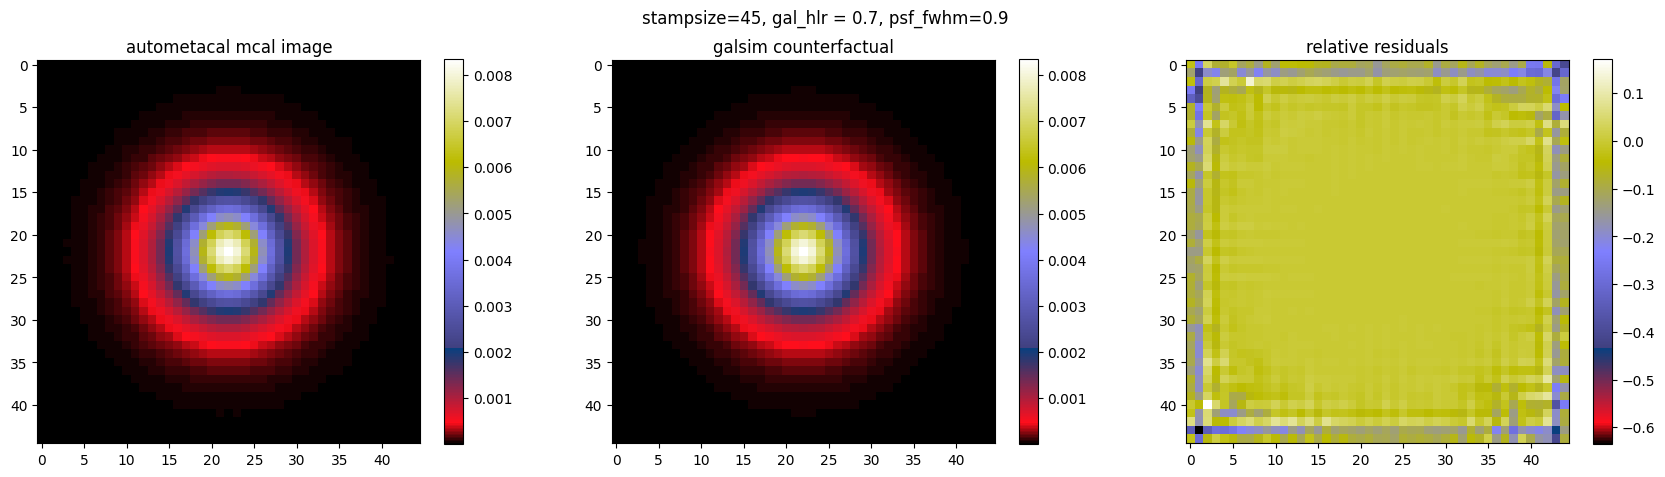

In [12]:
obj0 = galsim.Exponential(half_light_radius=gal_hlr)
counterfact = galsim.Convolve([reconv_psf,obj0])
counterfact = tf.expand_dims( tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

figure(figsize=(21,5))
suptitle('stampsize=45, gal_hlr = 0.7, psf_fwhm=0.9')
subplot(131)
title('autometacal mcal image')
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0],cmap='gist_stern');colorbar()
subplot(132)
title('galsim counterfactual')
imshow(counterfact[0],cmap='gist_stern');colorbar()

subplot(133)
title('relative residuals')
imshow((autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])/counterfact[0],cmap='gist_stern');colorbar()
savefig('autometacal_vs_galsim_65_bigger_padding.png')

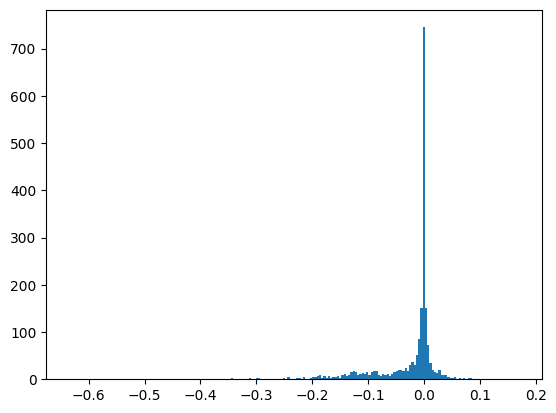

In [13]:
relative_residuals=(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])/counterfact[0]
hist(relative_residuals.numpy().flatten(),bins=200);

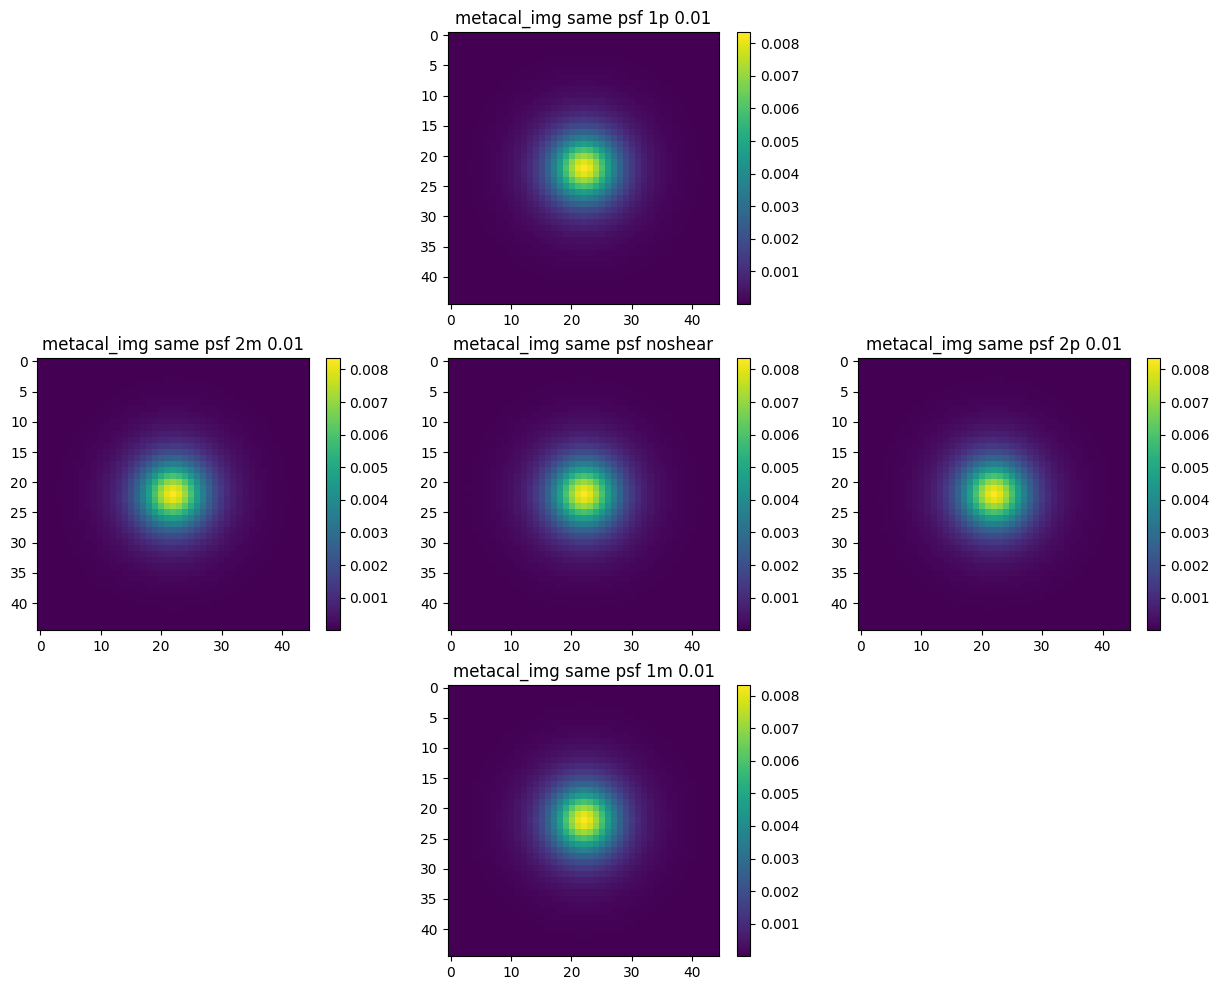

In [14]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0]); colorbar()
title('metacal_img same psf noshear')

subplot(332)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[step,0.0]])[0]); colorbar()
title(f'metacal_img same psf 1p {step}')

subplot(338)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-step,0.0]])[0]); colorbar()
title(f'metacal_img same psf 1m {step}')

subplot(336)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,step]])[0]); colorbar()
title(f'metacal_img same psf 2p {step}')

subplot(334)
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-step]])[0]); colorbar()
title(f'metacal_img same psf 2m {step}')
savefig('problems1.png',bbox_inches='tight')

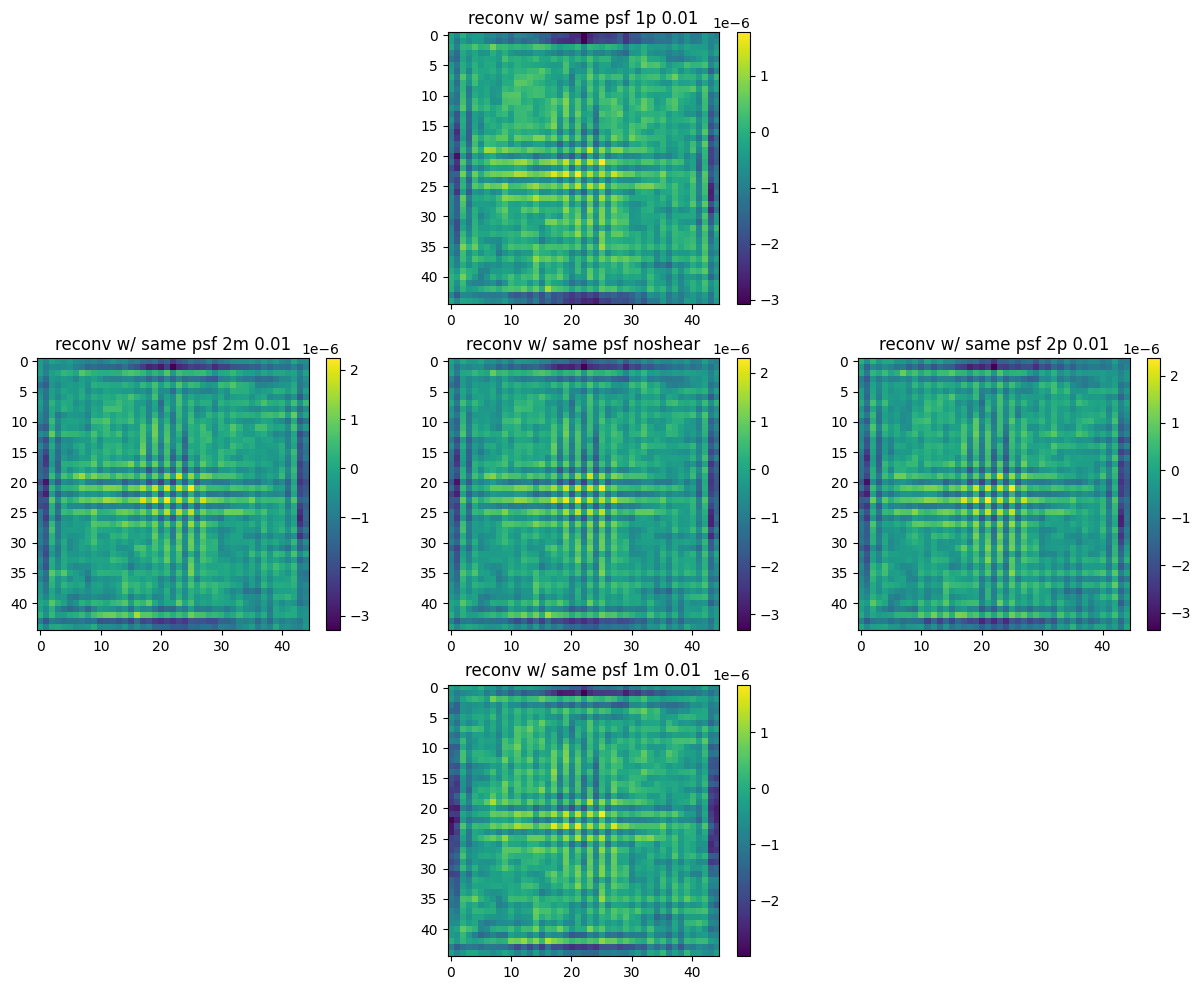

In [15]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])
title('reconv w/ same psf noshear');colorbar()

subplot(332)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1p {step}');colorbar()

subplot(338)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=-step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[-step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1m {step}');colorbar()

subplot(336)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2p {step}');colorbar()

subplot(334)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=-step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,-step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2m {step}');colorbar()
savefig('problems2.png',bbox_inches='tight')

In [16]:
banana();

NameError: name 'banana' is not defined

## Simple Ellipticity Measurements

In [ ]:
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0])
print(f'0shear  g1={g1: .4f},  g2={g2: .4f}')
print('--------------------------------')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.05,0.0]])[0])
print(f'1p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-.05,0.0]])[0])
print(f'1m .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.05]])[0])
print(f'2p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(autometacal.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-.05]])[0])
print(f'2m .05  g1={g1: .4f},  g2={g2: .4f}')

## Autodiff

In [ ]:
e, R =amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
for e, R in zip(e,R):
  calibre=tf.linalg.inv(R) @ tf.reshape(e,[2,1])
  print(f'g1 = {calibre[0,0]: .5f}, g2 = {calibre[1,0]: .5f}')

In [ ]:
e, R = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre0 = tf.linalg.inv(R[0]) @ tf.reshape(e[0],[2,1])

## Single image comparison between Autodiff and Finite diff

In [ ]:
steps = np.logspace(-5,0,100)
ef_list = []
R11f_list = [] 
R12f_list = []
R21f_list = []
R22f_list = []
for step in steps:
  
  e_f, R_f=amc.get_metacal_response_finitediff(gal_images[tf.newaxis,0],psf_images[tf.newaxis,0],reconv_psf_image,step,get_ellipticities)
  R11f_list.append(R_f[0,0,0])
  R12f_list.append(R_f[0,0,1])
  R21f_list.append(R_f[0,1,0])
  R22f_list.append(R_f[0,1,1])
  try:
    calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f,[2,1])
    ef_list.append(np.sqrt(sum(calibre_f**2)))
    
  except:
    ef_list.append(np.nan)
    print('Ops!')

In [ ]:
e = np.sqrt(sum(calibre0**2))

In [ ]:
figure(figsize=(16,9))
plot(steps,abs(e-np.array(ef_list)) )
xscale('log')
yscale('log')
ylabel('$|e_{auto} - e_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
savefig(f'autofinite{time.time()}.jpeg',bbox_inches='tight')

In [ ]:
R11 = R[0,0,0]
R12 = R[0,0,1]
R21 = R[0,1,0]
R22 = R[0,1,1]

In [ ]:
figure(figsize=(16,9))
plot(steps,abs(R11-np.array(R11f_list)),label="$R_{11}$" )
plot(steps,abs(R12-np.array(R12f_list)),label="$R_{12}$" )
plot(steps,abs(R21-np.array(R21f_list)),label="$R_{21}$" )
plot(steps,abs(R22-np.array(R22f_list)),label="$R_{22}$" )
plot([1e-2,1e-2],[1e-7,1e-2],'k-')
xscale('log')
yscale('log')
#ylim([1.5e-4,3e-4])
ylabel('$|R_{auto}-R_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
legend(fontsize=20)
savefig(f'autofinite_response_log.jpeg',bbox_inches='tight')

## Galaxy Batches

In [ ]:
from scipy.stats import truncnorm

In [ ]:
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
Ngal=500
while i<Ngal :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garray = np.array(g_list)

In [ ]:

gal_images, psf_images = make_data(N=Ngal,
                                  psf_noise = psf_noise,
                                  img_noise = 1*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

In [ ]:
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.png",bbox_inches="tight")

* *This is not an École Polytechnique ad.* :-)

In [ ]:
style.use('ggplot')
figure(figsize=(20,10))
box_size=.2
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)

subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)
savefig("linearity_zoomed.png",bbox_inches="tight")


## Averaging the response comparison over many galaxies

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)    
e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')

plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel(" $R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response.png',bbox_inches='tight')

In [ ]:
banana();

In [ ]:
tf.float32.size*45*45*9*100

In [ ]:
tf.config.experimental.get_memory_info('GPU:0')

## Higher Noise

10x noise

In [ ]:
gal_images, psf_images = make_data(N=1000,
                                  psf_noise = psf_noise,
                                  img_noise = 10*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

In [ ]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')

plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')
#ylim([1e-6,1e0])
xlabel('step size',fontsize=20)
ylabel(" $R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response_10x_noise.png',bbox_inches='tight')

100x noise

In [ ]:
gal_images, psf_images = make_data(N=1000,
                                  psf_noise = psf_noise,
                                  img_noise = 20*img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

In [ ]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [ ]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,
                                                         method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
R_finite = np.array(R_finite_list)

e_auto, R_auto = autometacal.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)

In [ ]:
style.use('ggplot')
R_finite=np.array(R_finite_list)
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0]),axis=1),label="R_{11}",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1]),axis=1),label="R_{22}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0]),axis=1)),label="R_{12}",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1]),axis=1)),label="R_{21}",color='darkblue')
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('median_response_20x_noise.png',bbox_inches='tight')